David Fleming 2015

University of Washington

# Snapshot Analysis Pipeline

This script searches for and reads in all snapshots in the CWD, analyzes them, and stores/processes arrays of quantities on interest.

In [189]:
#Imports
%matplotlib inline

#Imports
import pynbody
SimArray = pynbody.array.SimArray
from matplotlib.pylab import *
import matplotlib.pylab as plt
import pynbody.plot.sph as sph
import numpy as np
from scipy import interpolate
import matplotlib.lines as mlines
import matplotlib.colors
from matplotlib.pyplot import figure, show, rc

import os
import diskpy
from diskpy.ICgen import *

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,6)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 20.0

# Setup
User must provide to the variable "cwd" the full directory name of the dir where the data is.  Then, set the flags to get the analysis you want.

In [190]:
#Tell code where data is
cwd = '/astro/users/dflemin3/Desktop/sims/k38_e_0_dEta_0.005_100yrs'
os.chdir(cwd)

In [191]:
#Flags to control output.  Can be passed as command line arguments if I make this a script in the future
massFlag = True
torqueFlag = True
resFlag = True
comFlag = True

In [192]:
#Initialize variables to be determined later
steps = 0
nSteps = 0
dDelta = 0
m_disk = 0

# Read in .param file.
Read in .param file in the directory if it exists.  Then initialize the relevant data structures.

In [193]:
#Read in .param file and extract info I need

#Find param file if it exists
for file in os.listdir(cwd):
    if file.endswith(".param"):
        filename = file
        break
    else:
        filename = "Invalid"
        
#No file name so give warning before program dies
if filename == "Invalid":
    print "No .param file found!"

else:
    with open(filename) as f:
        lines = f.readlines()

    #Iterate over lines in param file, look for ones of interest
    #All lines of the form: cParamName = value
    for line in lines:
        line = str(line).rstrip('\n')

        #Look for file name
        if "achOutName" in line:
            name = line.split()[-1]

        #Look for iOutInterval
        if "iOutInterval" in line:
            steps = int(line.split()[-1])
    
        #Look for number of steps
        if "nSteps" in line:
            nSteps = int(line.split()[-1])

        #Look for dDelta
        if "dDelta" in line:
            dDelta = float(line.split()[-1])

In [194]:
#Given the variables just read in, compute how many output files I have to read in, then allocate data for the info I want
num = nSteps/steps + 1
bins = 50

#Resonance finding parameters
m_min = 1
l_min = 1
m_max = 3
l_max = 3

#Now allocate numpy arrays to hold information I care about so I can plot and things

#Allocate space for orbital elements

orbElems = np.zeros((num,6))
diskOrbElems = np.zeros((num,6,bins))
#Int flags to select orbital elements
[e,a,inc,loan,w,nu] = [0,1,2,3,4,5]

#Other variables of interest
circFreq = np.zeros(num)
comBinary = np.zeros((num,3))
comVelBinary = np.zeros((num,3))
comVelDisk = np.zeros((num,3))
diskAverage = np.zeros((num,6))
diskE = np.zeros(num)
diskL = np.zeros(num)
comCut = np.zeros((num,3))
mass = np.zeros((num,2))
mass_enclosed = np.zeros(num)
netTorque = np.zeros((num,3))
tau = np.zeros((num,bins,3)) #snapshot, radius, 3 components of torque/mass
dedt = np.zeros((num,bins))
ILR = np.zeros((m_max,l_max))
OLR = np.zeros((m_max,l_max))
CRR = np.zeros((l_max))
omega_d = np.zeros((num,bins))
kappa = np.zeros((num,bins))
r = np.zeros((num,bins))
time = np.linspace(0,dDelta/(2.0*np.pi)*nSteps,num)

# Read snapshots
Reads in all tipsy snapshots and from the data calculates the parameters of interest for later analysis.

In [195]:
#%%capture
#Read in files, if I can't open a file, tell user why/which one
#Use capture to suppress stderr output
#First, check to see if I have an archive file for this data set.
#Look in the directory where data is!
#Assume if one exists, they all do

if filename != "Invalid":
    archiveName = name + "_archive.npz"
else:
    archiveName = "k38_archive.npz" #Default
    
if (not os.path.exists(archiveName)):
    #No archive file in directory, so load data from snaps
    #Read in initial conditions of the form name.std
    
    print "Loading snapshots, storing in {0} archive.".format(name)
    
    try:
        snap = name + ".std"
        s = pynbody.load(snap)
        
        #Subtract off center of mass
        tmpDiskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
        s['pos'] -= tmpDiskCom
    except RuntimeError:
        print "No initial conditions found!  Was looking for {0}".format(snap)
    else:
        #Get binary stellar parameters
        x1 = s.stars[0]['pos']
        x2 = s.stars[1]['pos']
        v1 = s.stars[0]['vel']
        v2 = s.stars[1]['vel']
        m1 = s.stars[0]['mass']
        m2 = s.stars[1]['mass']
        mass[0,:] = [m1,m2]

        #Calculate disk mass
        m_disk = np.sum(s.gas['mass'])

        #Orbital Elements Calculations
        orbElems[0,:] = AddBinary.calcOrbitalElements(x1, x2, v1, v2, m1, m2)
        circFreq[0] = AddBinary.calcCircularFrequency(x1,x2,v1,v2,m1,m2)
        
        #Compute inner, outer radii and radius+bins for future torque/mass calculations
        r_in = 1.5*orbElems[0,a]
        res_r_in = 2.0*orbElems[0,a]
        r_EOLR = 2.08*orbElems[0,a] #Location of 3:1 EOLR
        cut = 3.0 #au cutoff as per Tom's suggestion
        edge = 10.0 #au, disk shouldn't exist beyond here
        r_out = cut
        res_r_out = 10.0*orbElems[0,a]
        
        #Compute disk radial bins to use throughout computation
        r[0,:], rBinEdges = binaryUtils.calcDiskRadialBins(s,r_in,r_out,bins)
        r[:,:] = r[0,:]
        
        #Compute resonances
        OLR, ILR, CRR = binaryUtils.calc_LB_resonance(s,m_min=m_min,m_max=m_max,l_min=l_min,l_max=l_max)
        
        #Compute disk quantities
        diskOrbElems[0,:,:] = binaryUtils.orbElemsVsRadius(s,rBinEdges,average=True)
        diskAverage[0,:] = binaryUtils.diskAverage(s,r_out=cut,bins=bins)
        mass_enclosed[0] = np.sum(s.gas['mass'][s.gas['rxy'] < r_EOLR])
        
        #Center of Mass calculations
        comBinary[0] = AddBinary.calcCOM(m1,m2,x1,x2)
        comCut[0] = binaryUtils.computeCOM(s.stars,s.gas,cutoff=cut,starFlag=False,gasFlag=True)
        comVelBinary[0] = binaryUtils.computeVelocityCOM(s,cutoff=cut,starFlag=True,gasFlag=False)
        comVelDisk[0] = binaryUtils.computeVelocityCOM(s,cutoff=cut,starFlag=False,gasFlag=True)
        
        #Disk energy, angular momentum calculations
        x1_gas = s.gas['pos']
        x_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'au')
        v1_gas = s.gas['vel']
        v_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'km s**-1')
        gas_m = s.gas['mass'].in_units('g')
        cm = SimArray(tmpDiskCom,'au')

        #Compute semimajor axis, longitude of perihelion (relative to that of bin) for ALL gas particles
        gas_a = AddBinary.calcSemi(x1_gas,cm,v1_gas,v_zero,m1,m2)
        gas_e = AddBinary.calcEcc(x1_gas,cm,v1_gas,v_zero,m1,m2)
        diskE[0] = np.sum(AddBinary.compute_E(gas_a, m1+m2, gas_m)) #a, m1, m2
        diskL[0] = np.sum(AddBinary.compute_L(gas_a, gas_e, m1+m2, gas_m)) #a, e, m1 ,m2
        
        #Torque calculations
        if torqueFlag:
            netTorque[0,:] = binaryUtils.calcNetTorque(s.stars,s.gas)

        #Resonance calculations
        if resFlag:
            tau[0,:,:] = binaryUtils.torqueVsRadius(s,rBinEdges) #Torque per radial bin
            dedt[0,:] = binaryUtils.calcDeDt(s.stars,tau[0,:,:]) #Send in all the torque

    #end reading in ICs

    #Start counting other snapshots    
    i = 1

    while i < num:
        t = str(i*steps)
        pad = t.rjust(6, '0')
        snap = name + "." + pad
        try:
            s = pynbody.load(snap)
            
            #Subtract off center of mass
            tmpDiskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
            s['pos'] -= tmpDiskCom
        except RuntimeError:
            print "No file found!  Was looking for {0}".format(snap)
            break
        else:
            #Get binary stellar parameters
            x1 = s.stars[0]['pos']
            x2 = s.stars[1]['pos']
            v1 = s.stars[0]['vel']
            v2 = s.stars[1]['vel']
            m1 = s.stars[0]['mass']
            m2 = s.stars[1]['mass']
            mass[i,:] = [m1,m2]

            #Orbital Element Calculations
            orbElems[i,:] = AddBinary.calcOrbitalElements(x1, x2, v1, v2, m1, m2)
            circFreq[i] = AddBinary.calcCircularFrequency(x1,x2,v1,v2,m1,m2)
            
            #Center of Mass calculations
            comBinary[i] = AddBinary.calcCOM(m1,m2,x1,x2)
            comCut[i] = binaryUtils.computeCOM(s.stars,s.gas,cutoff=cut,starFlag=False,gasFlag=True)
            comVelBinary[i] = binaryUtils.computeVelocityCOM(s,cutoff=cut,starFlag=True,gasFlag=False)
            comVelDisk[i] = binaryUtils.computeVelocityCOM(s,cutoff=cut,starFlag=False,gasFlag=True)
            
            #Disk energy, angular momentum calculations
            x1_gas = s.gas['pos']
            x_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'au')
            v1_gas = s.gas['vel']
            v_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'km s**-1')
            gas_m = s.gas['mass'].in_units('g')
            cm = SimArray(tmpDiskCom,'au')

            #Compute semimajor axis, longitude of perihelion (relative to that of bin) for ALL gas particles
            gas_a = AddBinary.calcSemi(x1_gas,cm,v1_gas,v_zero,m1,m2)
            gas_e = AddBinary.calcEcc(x1_gas,cm,v1_gas,v_zero,m1,m2)
            diskE[i] = np.sum(AddBinary.compute_E(gas_a, m1+m2, gas_m)) #a, m1, m2
            diskL[i] = np.sum(AddBinary.compute_L(gas_a, gas_e, m1+m2, gas_m)) #a, e, m1 ,m2
            
            #r[i,:], rBinEdges = binaryUtils.calcDiskRadialBins(s,r_in,r_out,bins)
            diskOrbElems[i,:,:] = binaryUtils.orbElemsVsRadius(s,rBinEdges,average=True)
            diskAverage[i,:] = binaryUtils.diskAverage(s,r_out=cut,bins=bins)
            mass_enclosed[i] = np.sum(s.gas['mass'][s.gas['rxy'] < r_EOLR])
            
            #Torque calculations
            if torqueFlag:
                netTorque[i,:] = binaryUtils.calcNetTorque(s.stars,s.gas)

            #Resonance calculations
            if resFlag:
                tau[i,:,:] = binaryUtils.torqueVsRadius(s,rBinEdges)
                dedt[i,:] = binaryUtils.calcDeDt(s.stars,tau[i,:,:]) #send in all the torque
            
            i += 1

    #end loop, save data in respective archives
    np.savez(archiveName,orbElems=orbElems,mass=mass,time=time,
             tau=tau,dedt=dedt,ILR=ILR,OLR=OLR,CRR=CRR,circFreq=circFreq,
             r=r,diskOrbElems=diskOrbElems,netTorque=netTorque,
            comBinary=comBinary,comCut=comCut,diskAverage=diskAverage,
            comVelBinary=comVelBinary,comVelDisk=comVelDisk,mass_enclosed=mass_enclosed,
            diskE=diskE,diskL=diskL)
    
#If there is an archive, load data from past archive
else:
    print "Loading from {0} archive.".format(name)
    
    archiveName = name + '_archive.npz'

    #Load from archive
    archive = np.load(archiveName)
    orbElems = archive['orbElems']
    circFreq = archive['circFreq']
    diskOrbElems = archive['diskOrbElems']
    netTorque = archive['netTorque']
    time = archive['time']
    mass = archive['mass']
    tau = archive['tau']
    dedt = archive['dedt']
    ILR = archive['ILR']
    OLR = archive['OLR']
    CRR = archive['CRR']
    r = archive['r']
    comBinary = archive['comBinary']
    comCut = archive['comCut']
    diskAverage = archive['diskAverage']
    comVelBinary = archive['comVelBinary']
    comVelDisk = archive['comVelDisk']
    mass_enclosed = archive['mass_enclosed']
    diskE = archive['diskE']
    diskL = archive['diskL']

Loading from k38_snap archive.


# Eccentricity Analysis

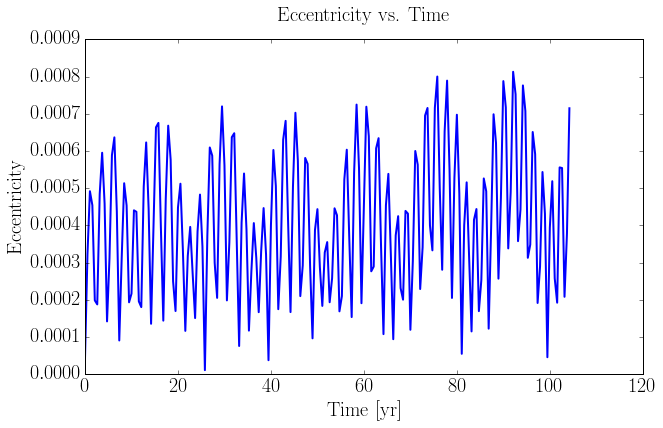

In [196]:
#Produce plot of e vs time
plt.plot(time,orbElems[:,e],label="Simulation",linewidth=2)
plt.ylabel("Eccentricity")
plt.xlabel("Time [yr]")
plt.title("Eccentricity vs. Time",y=1.04)

#print repr(time[:])
#print repr(orbElems[:,e])
#plt.savefig("10.27.2015_binEVsTime_e_0.05_520yr.pdf")

# Semimajor Axis Analysis

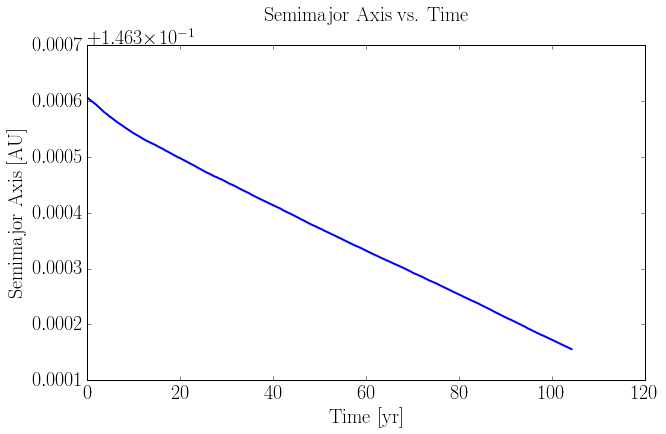

In [197]:
#Produce plot of a vs time
plt.plot(time,orbElems[:,a],linewidth=2)
plt.ylabel("Semimajor Axis [AU]")
plt.xlabel("Time [yr]")
plt.title("Semimajor Axis vs. Time",y=1.06)

#print repr(orbElems[:,a])

In [198]:
def semiEccifit(a,a0,e,e0,c=4.42):
    return a0 * np.exp(-(e-e0)/c)

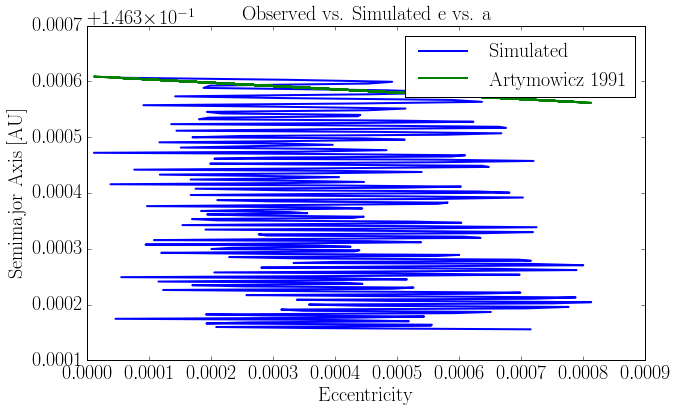

In [199]:
plt.plot(orbElems[:,e],orbElems[:,a],label='Simulated',linewidth=2)
plt.plot(orbElems[:,e],semiEccfit(orbElems[:,a],orbElems[0,a],orbElems[:,e],orbElems[0,e]),
        label=r'Artymowicz 1991',linewidth=2)

plt.title("Observed vs. Simulated e vs. a")
plt.xlabel("Eccentricity")
plt.ylabel("Semimajor Axis [AU]")
plt.legend()

#plt.savefig("eVsAArty1991fit.pdf")

# Center of Mass
Plot the center of mass location for the binary system and the entire system (binary + system) in order to track how it changes over time.  Ideally, the CoM would remain at the origin (0,0,0) but in practice this doesn't happen.  The below plots help gauge the deviation.

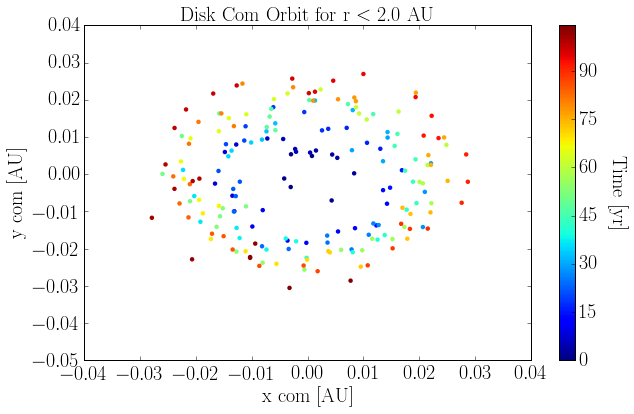

In [200]:
cArr = np.sqrt(AddBinary.dotProduct(comVelDisk,comVelDisk))
cArr = time
scat = plt.scatter(comCut[:,0],comCut[:,1],c=cArr,edgecolor='None')
cbar = plt.colorbar(scat)
cbar.set_label("Time [yr]", labelpad=30, rotation=270)

plt.xlabel(r"x com [AU]")
plt.ylabel(r"y com [AU]")
plt.title("Disk Com Orbit for r $<$ {0} AU".format(2.0))
#plt.savefig("lateLowEccDiskComOrbit.pdf",bbox_inches='tight')

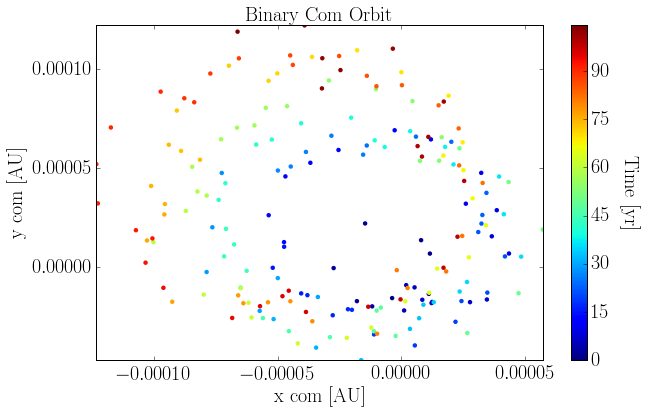

In [201]:
cArr = np.sqrt(AddBinary.dotProduct(comVelBinary,comVelBinary))
cArr = time
scat = plt.scatter(comBinary[:,0],comBinary[:,1],c=cArr,edgecolor='None')
plt.xlim(comBinary[:,0].min(),comBinary[:,0].max())
plt.ylim(comBinary[:,1].min(),comBinary[:,1].max())
cbar = plt.colorbar(scat)
#plt.xlim(xArr.min(),xArr.max())
#plt.ylim(yArr.min(),yArr.max())
plt.xlabel(r"x com [AU]")
plt.ylabel(r"y com [AU]")
cbar.set_label("Time [yr]", labelpad=30, rotation=270)
plt.title("Binary Com Orbit")
#plt.savefig("lateLowEccBinComOrbit.pdf",bbox_inches='tight')

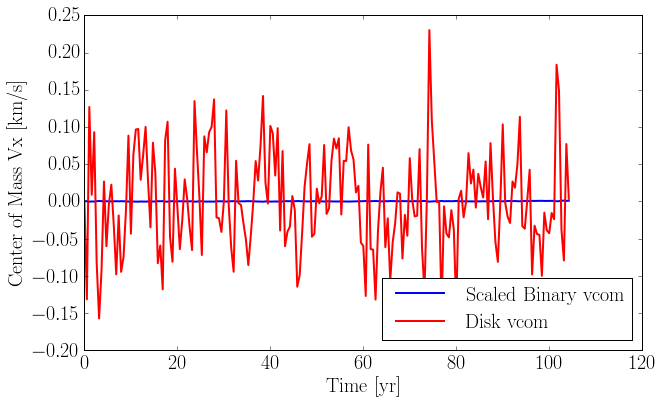

In [202]:
if comFlag:
    plt.plot(time,comVelBinary[:,0],color='blue',label='Scaled Binary vcom',linewidth=2)
    plt.plot(time,comVelDisk[:,0],color='red',label='Disk vcom',linewidth=2)
    plt.xlabel("Time [yr]")
    plt.ylabel("Center of Mass Vx [km/s]")
    plt.legend(loc = "lower right")  
        
else:
    print "Skipping center of mass plots."
    print

# Accretion
Plot the change in stellar mass vs. time and estimate the mean accretion rate $\dot{M}$ in $M_{\odot}/yr$.  For disks with surface densities that go as $r^{-1/2}$, you expect something in around $10^{-8}$ to $10^{-7}$.

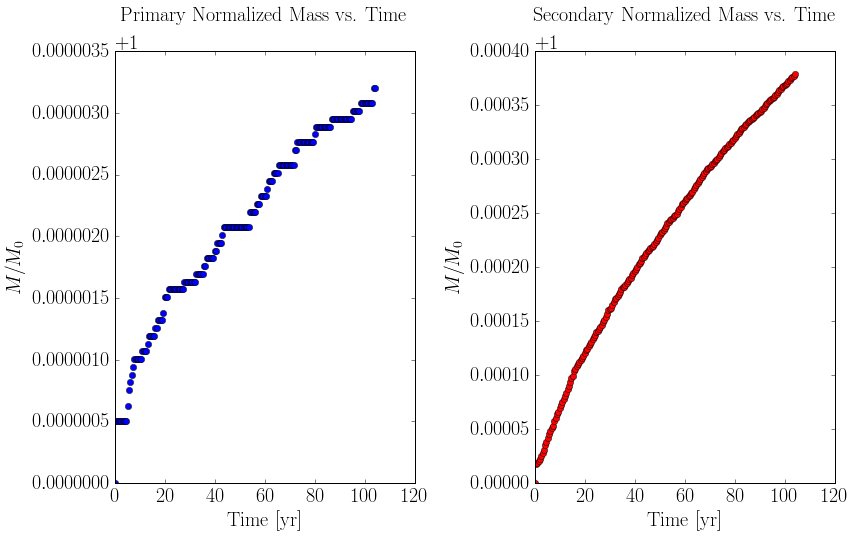

Mean accretion rate = 9.34121808537e-07 solar masses per year.


In [203]:
if massFlag:
    #Create figure, make it look nice
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1,
                        bottom=0.0, top=1.0,
                        hspace=0.0, wspace=0.4)

    #Primary
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(time,mass[:,0]/mass[0,0],'o',color='blue',label="Primary")
    ax1.set_ylabel(r"$M/M_0$")
    ax1.set_xlabel("Time [yr]")
    ax1.set_title("Primary Normalized Mass vs. Time",y=1.06)

    #Secondary
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(time,mass[:,1]/mass[0,1],'o',color='red',label="Secondary")
    ax2.set_ylabel(r"$M/M_0$")
    ax2.set_xlabel("Time [yr]")
    ax2.set_title("Secondary Normalized Mass vs. Time",y=1.06)

    plt.show()
    
    #Now calculate mean accretion rate
    deltaM = (mass[-1,0] - mass[0,0]) + (mass[-1,1] - mass[0,1])
    mDot = deltaM/(time[-1])
    print "Mean accretion rate =",mDot, "solar masses per year."
    
else:
    print "Skipping Mass plots."
    print

#Torque as a function of radius
Plot the torque per unit mass on binary system due to the CB disk as a function of disk radius.  

First compute the next force on each star due to every single gas particle in the given radial bin.  For torque, $\tau = \vec{r} \times \vec{F}$, take the moment arm to be the distance from the center of mass of the entire system to the given star.  The force vector points from the given star to the collection of gas particles considered. I'll normalize the torque on each star by that star's mass.  Sum up the torque on each star to get the result.

Procedure:
>Calculate the time-averaged net torque on the binary due to the disk at a given radius.  For time-average, simply take mean of torque/mass vs. radius calculations at each radius over range of snapshots.  Note: Must ensure that snapshots are a few binary orbits apart for this to make sense.  The main effects are expected to happen at the apastron when the interaction is strongest due to those parts of the disk rotating more slowly than the binary itself (Artymowics+1991).

Vectors:
>$\vec{r}$ points from the center of mass to the star while the force is due to the gas particles pulling on the star.  Reminder: the radius points from the axis of rotation (center of mass in this case) to the rotating object.  Also, $\vec{F}$ points from the star to the gas.

What I expect:
>I expect to see a negative net torque.  Since the system rotates CCW, a torque < 0 would imply angular momentum is leaving the system and eccentricity increases corresponding to what is observed.

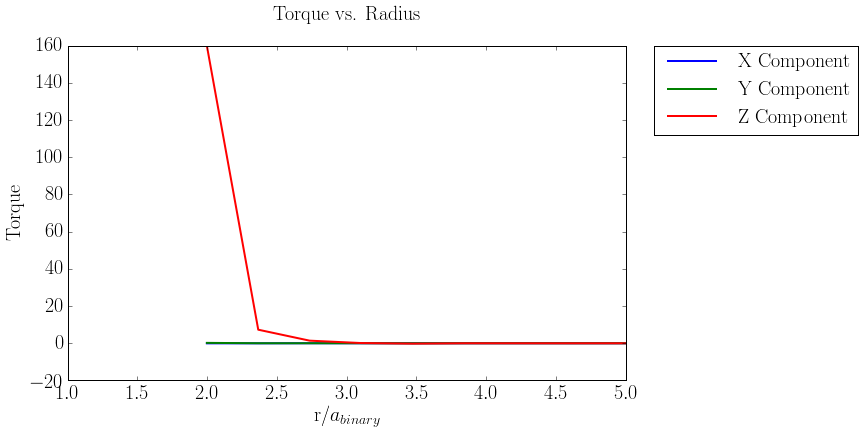

In [204]:
#Plot 3 components of normalize torque for ith snapshot
if torqueFlag:
    
    norm = 1#np.max(tau)
    plt.plot(r[0]/orbElems[0,a],np.sum(tau[:,:,0],axis=0)/norm,label="X Component",linewidth=2)
    plt.plot(r[0]/orbElems[0,a],np.sum(tau[:,:,1],axis=0)/norm,label="Y Component",linewidth=2)
    plt.plot(r[0]/orbElems[0,a],np.sum(tau[:,:,2],axis=0)/norm,label="Z Component",linewidth=2)

    
    #Make plot look nice
    plt.title("Torque vs. Radius",y=1.06)
    plt.xlabel("r/$a_{binary}$")
    plt.xlim(1,5)
    plt.ylabel("Torque")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
else:
    print "Skipping torque calculations."

# Torque Notes:

The z component of the torque dominates as expected for a thin, (initially) axisymmetric disk.  The z component torques on the binary causing the system's eccentricity to slowly increase over time.  Since torques can't occur for a perfectly axisymmetric system, some sort of resonance must be at work.  Given the predictions of Artymowicz+1991, we'd expect the Outer Lindblad Resonances (OLR) to provide most of the torque.

#Resonance Calculations

Plot the change in eccentricity over time (de/dt) vs. the disk orbital frequency $\Omega_{disk}$ to see at which location in the disk the majority of the torque comes from.  From these locations, we can see if they correspond to a resonance as theoretically expected.

Theory:

First, we must compute de/dt as a function of radius.  To do this, I took the time derivative of the equation for the eccentricity of a binary system
>$de/dt = d/dt\left( \sqrt{1 + \frac{2 \epsilon h^2}{\mu^2}} \right) =  \left( 1 + \frac{2 \epsilon h^2}{\mu^2} \right)^{-1/2} \left( \frac{2 \epsilon h}{\mu^2} \right) dh/dt $ 
    
where dh/dt is the torque per unit mass at a given disk radius, $\mu = G(m_1+m_2)$  and the specific energy $\epsilon$ is assumed roughly constant since the semimajor axis of the orbit does not change much.  Note, only the z component of dh/dt is used since as shown in the plot above, it dominates.


In order to calculate the location of the resonances in the circumbinary disk, the following formulas are used:
>Lindblad Resonance: $m(\Omega_{disk} - \Omega_{binary}) = \pm l \kappa$

for integer m, l.  $\Omega_{disk}$ is the angular frequency of a annulus of gas in the disk, $\Omega_{binary}$ is the mean angular frequency of the binary system and defines the angular pattern speed of the binary potential that perturbs the disk.  $\kappa$ is the radial epicycle frequency of the same annulus of gas considered earlier.

>Corotation Resonance: $\Omega_{disk} = \Omega_{binary}/l$

for integer l.

Procedure:
>After calculating de/dt, I can plot this as a function of disk radius to see which locations in the disk cause the most torque on the binary.  Next given the resonance formulas, I compute the theoretical locations of the resonances for each snapshot and return the $\Omega$ in the disk where they exist.  I can then plot these against the de/dt curves to verify that de/dt is in fact due to resonances and to see which resonances contribute most strongly.

What I expect:
>In accordance with Artymowics+1991, I expect to see the Outer Lindblad Resonances (OLR) contribute to de/dt and dominate over the Inner (OLR) and Corotation (CRR).  Also since the inner disk is truncated via gap formation and has much less mass then the middle portions of the disk (i.e. where the power law component begins), I expect higher order l modes of the (m,l) OLR to contribute strongly.

Notes:

ILRs don't really contribute at all to any de/dt.  CRRs also seem to not do much except sometimes they do contribute to -dt/dt, but not on the same order of magnitude as OLRs contribute to +de/dt.

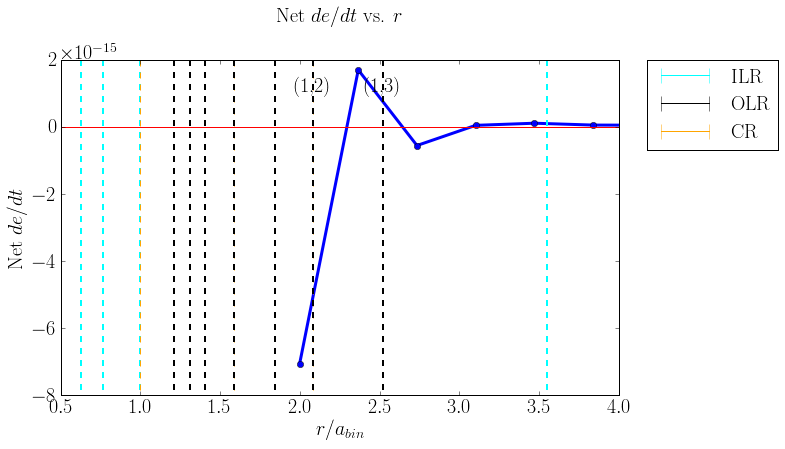

In [205]:
#Plot
if resFlag:
    
    norm = 1.0#np.max(dedt)

    #Plot de/dt with arbitrary normalization
    plt.plot(r[0]/orbElems[0,a],np.sum(dedt,axis=0)/norm,'-o',linewidth=3)
    plt.xlabel(r"$r / a_{bin}$")
    plt.ylabel(r"Net $de/dt$")
    plt.title(r"Net $de/dt$ vs. $r$",y=1.1)

    #Plot y = 0 for reference
    plt.axhline(y=0, xmin=-1,xmax=4.1,linewidth=1,color='red',linestyle='-')
    #plt.axvline(x=2.08,ymin=-1,ymax=1,linewidth=1,color='green',linestyle='-',label="3:1 OLR")
    
    #Plot LRs
    for m in range(0,m_max):
        for l in range(0,l_max):
            val = OLR[m,l]
            plt.axvline(x=val/orbElems[0,a],ymin=-1,ymax=1,linewidth=2,color='black',linestyle='--',zorder=20)
            if val/orbElems[0,a] > 2:
                text(val/orbElems[0,a], .22*np.fabs(np.sum(dedt)).max(),"(%s,%s)" % (m+1,l+1), ha='center', va='center')
            
            val = ILR[m,l]
            plt.axvline(x=val/orbElems[0,a],ymin=-1,ymax=1,linewidth=2,color='cyan',linestyle='--')

    for l in range(0,l_max):
        val = CRR[l]
        plt.axvline(x=val/orbElems[0,a],ymin=-1,ymax=1,linewidth=1,color='orange',linestyle='--')
        
        
    #Style plot
    plt.xlim(0.5,4)
    outer = mlines.Line2D([], [], color='black', marker='|',markersize=15, label='OLR')
    inner = mlines.Line2D([], [], color='cyan', marker='|',markersize=15, label='ILR')
    crr = mlines.Line2D([], [], color='orange', marker='|',markersize=15, label='CR')

    
    plt.legend(handles=[inner,outer,crr],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
    #plt.savefig("10.25.2015.dedtVsR_e_0.1032BigGap.pdf",bbox_inches='tight')
    
else:
    print "Skipping resonances calculation."

# Plotting Function
Define plotting function to plot LRs given snapshot number, dedt array, $\Omega_{disk}$ array, and $\kappa$ array.

TODO: Alter so it can accept/plot/discriminate between OLR,ILR,CRR or any combination

#de/dt vs True Anomaly ($\nu$).
Since $\nu$ = 0 at the argument of pericenter, would expect the largest torque and hence de/dt to occur at the apocenter, or at $\nu$ = 180 degrees.  This is because at the apocenter ($\nu$ = 180 degrees), the disk has the largest moment arm on the binary and hence the largest torque.  Here, I find that the peak lags 180 degrees implying that perhaps the primary causes a wake in the disk that then tugs on the secondary.

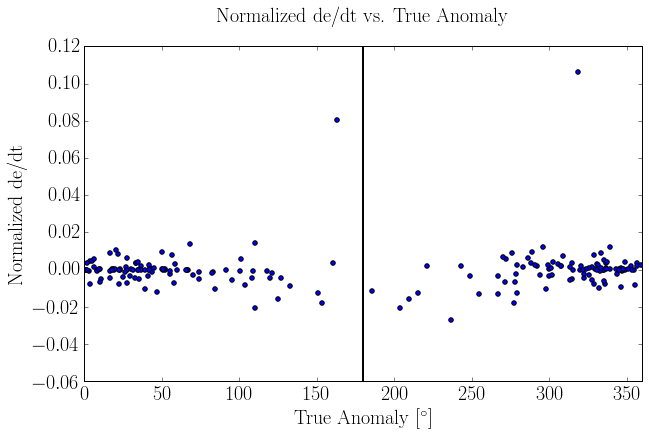

In [206]:
plt.scatter(orbElems[:,nu],np.sum(dedt,axis=1)/np.sum(np.fabs(dedt)))

plt.xlabel("True Anomaly [$^{\circ}$]")
plt.xlim(0,360)
#plt.ylim(dedt.min(),dedt.max())
plt.ylabel("Normalized de/dt")
plt.title("Normalized de/dt vs. True Anomaly",y=1.06)
plt.axvline(x=180, ymin=-1, ymax = 1, linewidth=2, color='k') #line at 180 degrees to see if max is there

#Orbital Elements Vs. Time
Plot the orbital elements (except e,a plotted above) vs time and select Poincare elements to examine the evolution of the binary system.

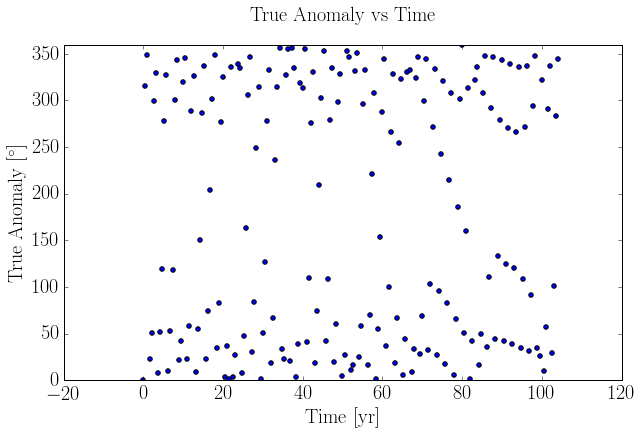

In [207]:
plt.scatter(time,orbElems[:,nu])

plt.xlabel("Time [yr]")
plt.ylim(np.min(orbElems[:,nu]),np.max(orbElems[:,nu]))
plt.ylabel("True Anomaly [$^\circ$]")
plt.title("True Anomaly vs Time",y=1.06)

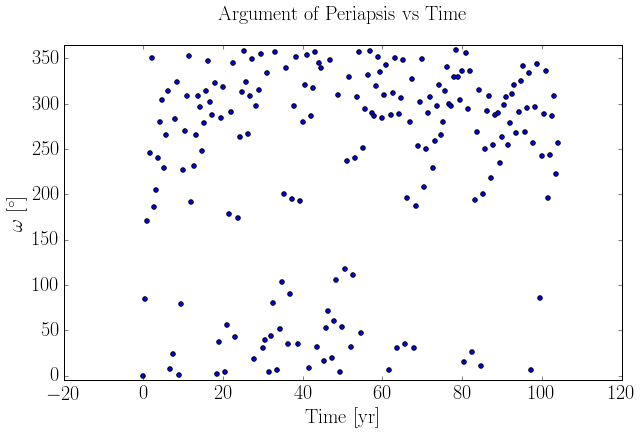

In [208]:
plt.scatter(time[0:],orbElems[0:,w])

plt.xlabel("Time [yr]")
plt.ylim(np.min(orbElems[0:,w]-5),np.max(orbElems[0:,w])+5)
plt.ylabel(r"$\omega$ [$^\circ$]")
plt.title("Argument of Periapsis vs Time",y=1.06)

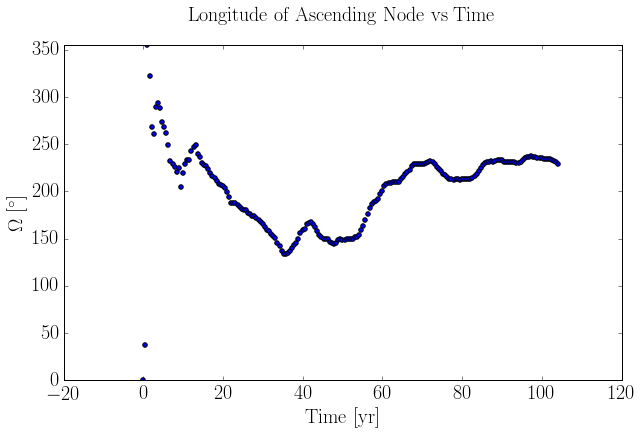

In [209]:
plt.scatter(time,orbElems[:,loan])

plt.xlabel("Time [yr]")
plt.ylim(np.min(orbElems[:,loan]),np.max(orbElems[:,loan]))
plt.ylabel(r"$\Omega$ [$^\circ$]")
plt.title("Longitude of Ascending Node vs Time",y=1.06)

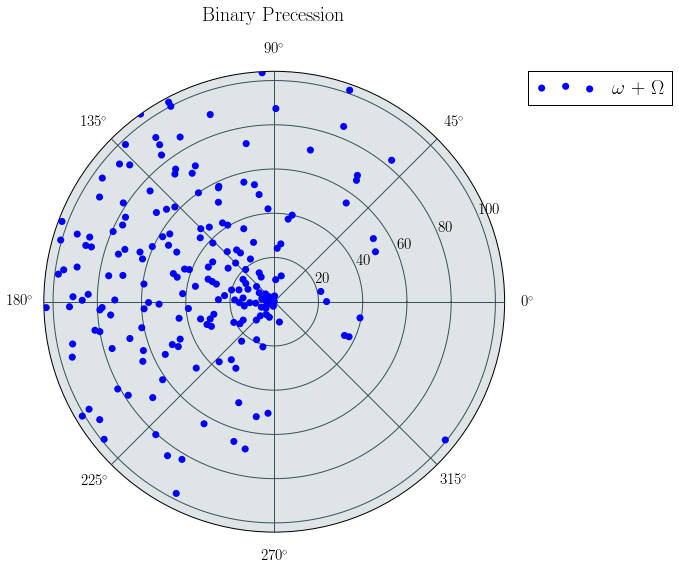

In [210]:
# radar green, solid grid lines
rc('grid', color='#38525c', linewidth=1, linestyle='-')
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)

# force square figure and square axes looks better for polar, IMO
fig = figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True, axisbg='#dfe5e7')

r_y = time 

w_x = (orbElems[:,w] + orbElems[:,loan])*np.pi/180.

#_x = orbElems[:,w]*(np.pi/180.)
#mega_x = orbElems[:,loan]*(np.pi/180.)
#ombo = w_x + Omega_x
ax.scatter(w_x, r_y,c='blue',s=50,zorder=10,edgecolor='None',label=r'$\omega$ + $\Omega$')
#x.scatter(Omega_x, r_y ,c='green',s=50,zorder=10,edgecolor='None',label=r'$\Omega$')
#ax.scatter(combo, r_y ,c='red',s=50,zorder=10,edgecolor='None',label=r'$\Omega$ + $\omega$')

ax.set_ylim(time[0],time[-1])
ax.set_title(r"Binary Precession",y=1.1)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("bigGapBinaryPrecession.pdf",bbox_inches='tight')

In [211]:
ri, ro = r[0].min(), r[0].max()
ri, ro = 0.25, 4

M1 = pynbody.array.SimArray(mass[0,0],'Msol')
M2 = pynbody.array.SimArray(mass[0,1],'Msol')
semi = pynbody.array.SimArray(orbElems[0,a],'au')
n = (np.sqrt(AddBinary.G*(M1+M2)/np.power(semi,3)).in_units('s**-1')*365.0) #cgs mean motion
T = np.power(ro,0.5)*np.power(ri,5./2.)/(0.5*n*0.1469**3)
T *= 8.0*np.pi*np.sum(mass[0,:])/m_disk
print T/AddBinary.YEARSEC

inf


/astro/apps6/opt/anaconda2.0/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars


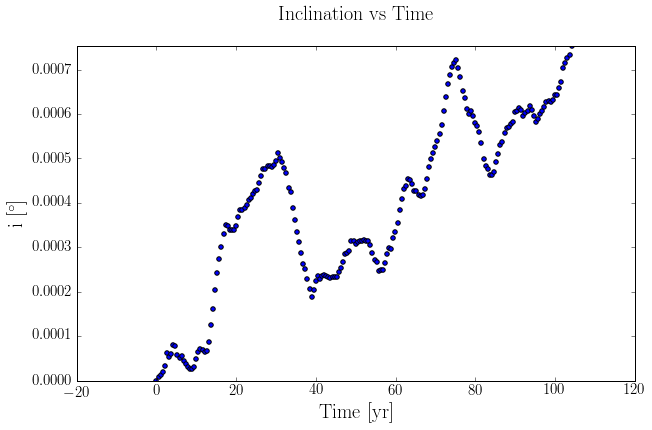

In [212]:
plt.scatter(time,orbElems[:,inc])

plt.xlabel("Time [yr]")
plt.ylim(0,np.max(orbElems[:,inc]))
plt.ylabel(r"i [$^\circ$]")
plt.title("Inclination vs Time",y=1.06)

#Plot Some Poincare Elements
Note: Ignore the first timestep as w=0 throws the range of everything off.

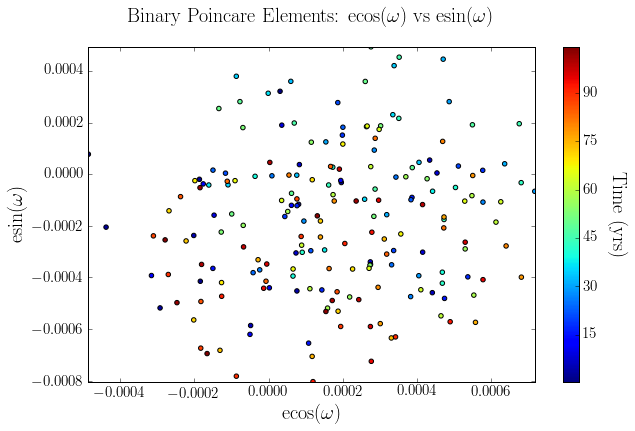

In [213]:
#Plot ecosw, esinw Poincare Elements (convert from degrees to radians!)
conv = np.pi/180.0
scat = plt.scatter(orbElems[1:,e]*np.cos(conv*orbElems[1:,w]),orbElems[1:,e]*np.sin(conv*orbElems[1:,w]),c=time[1:],cmap='jet')
cbar = plt.colorbar(scat)
cbar.set_label("Time (yrs)", labelpad=30, rotation=270)

#Make plot look nice
plt.xlim(min(orbElems[1:,e]*np.cos(conv*orbElems[1:,w])),max(orbElems[1:,e]*np.cos(conv*orbElems[1:,w])))
plt.ylim(min(orbElems[1:,e]*np.sin(conv*orbElems[1:,w])),max(orbElems[1:,e]*np.sin(conv*orbElems[1:,w])))
plt.title(r"Binary Poincare Elements: ecos($\omega$) vs esin($\omega$)",y=1.06)
plt.xlabel(r"ecos($\omega$)")
plt.ylabel(r"esin($\omega$)")
#plt.savefig("bigGapBinaryPoinElems.pdf",bbox_inches='tight')

In [214]:
def forcedEcc(binary,r):
    e_f = (binary.a/r)
    e_f *= 1.25*(binary.m1 - binary.m2)/(binary.m1 + binary.m2)

    return e_f

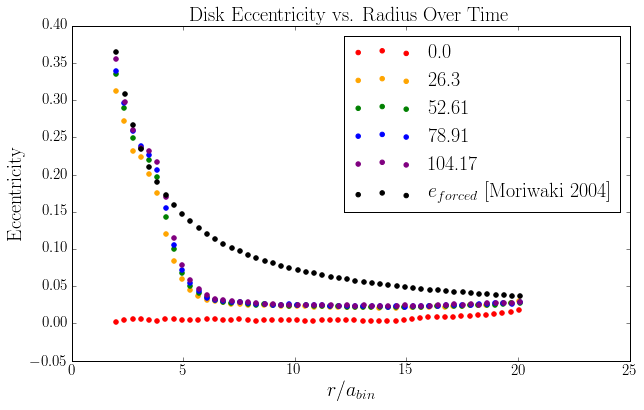

In [215]:
tmp = binary.Binary(orbElems[-1,:],mass[-1,0],mass[-1,1],'kepler')
e_forced = forcedEcc(tmp,r[-1])

vals = [0,50,100,150,198]
labels = [round(time[val],2) for val in vals]
e = 0
plt.scatter(r[vals[0],:]/orbElems[vals[0],a],diskOrbElems[vals[0],e,:],color='red',label=labels[0])
plt.scatter(r[vals[1],:]/orbElems[vals[1],a],diskOrbElems[vals[1],e,:],color='orange',label=labels[1])
plt.scatter(r[vals[2],:]/orbElems[vals[2],a],diskOrbElems[vals[2],e,:],color='green',label=labels[2])
plt.scatter(r[vals[3],:]/orbElems[vals[3],a],diskOrbElems[vals[3],e,:],color='blue',label=labels[3])
plt.scatter(r[vals[4],:]/orbElems[vals[4],a],diskOrbElems[vals[4],e,:],color='purple',label=labels[4])
plt.scatter(r[-1]/orbElems[-1,a],e_forced,color='black',label=r"$e_{forced}$ [Moriwaki 2004]")

plt.title("Disk Eccentricity vs. Radius Over Time")
plt.xlabel("$r/a_{bin}$")
plt.ylabel("Eccentricity")
#plt.ylim(0,1)
plt.legend()

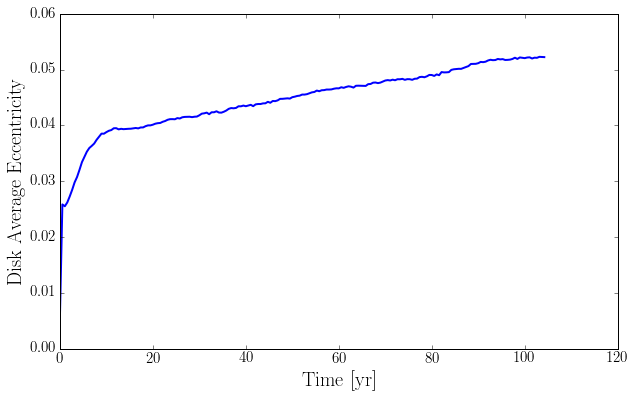

In [216]:
plt.plot(time,diskAverage[:,0],linewidth=2)
plt.xlabel("Time [yr]")
plt.ylabel("Disk Average Eccentricity")

#print repr(diskAverage[:,0])
#plt.savefig("10.26.2015_diskEVsTime_e_0.1032_bigGap.pdf")

<matplotlib.colorbar.Colorbar instance at 0x7f9dd4123368>

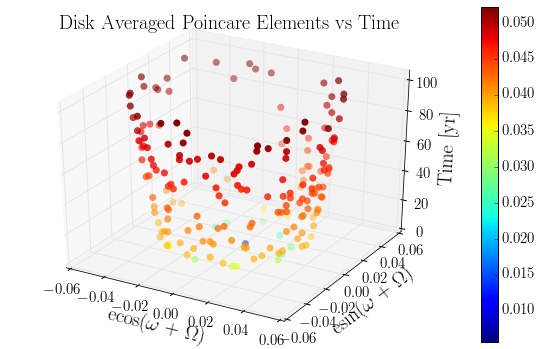

In [217]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

conv = np.pi/180.
xArr = diskAverage[:,0]*np.cos(conv*(diskAverage[:,3]*diskAverage[:,4]))
yArr = diskAverage[:,0]*np.sin(conv*(diskAverage[:,3]*diskAverage[:,4]))

x = xArr
y = yArr
z = time

color = np.sqrt(x**2 + y**2)
cm = plt.cm.get_cmap('jet')

scat = ax.scatter(x, y, z, c=color, marker='o',s=50,edgecolor='None',cmap=cm)
ax.set_xlabel(r'ecos($\omega$ + $\Omega$)')
ax.set_ylabel(r'esin($\omega$ + $\Omega$)')
ax.set_zlabel('Time [yr]')
ax.set_title("Disk Averaged Poincare Elements vs Time")
ax.set_zlim(time.min(),time.max())
#ax.view_init(90,90)
plt.colorbar(scat)

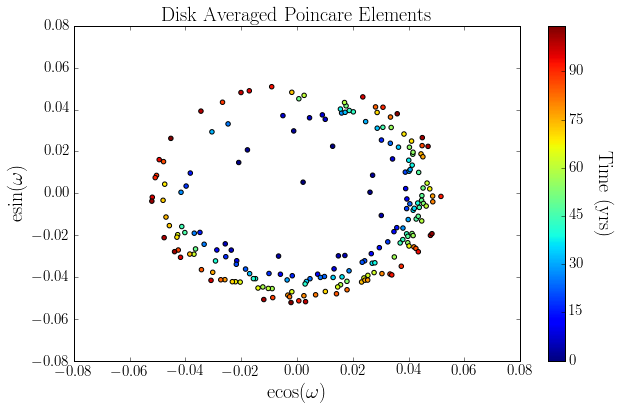

In [218]:
scat = plt.scatter(x,y,c=time)
cbar = plt.colorbar(scat)
cbar.set_label("Time (yrs)", labelpad=30, rotation=270)

plt.xlabel(r"ecos($\omega$)")
plt.ylabel(r"esin($\omega$)")
plt.title("Disk Averaged Poincare Elements")
#plt.savefig("bigGapDiskPoinElems.pdf",bbox_inches='tight')

# Plot quantities that look at whether L is conserved in the simulation as the binary loses it to the disk

(0.0, 104.16691025364551)

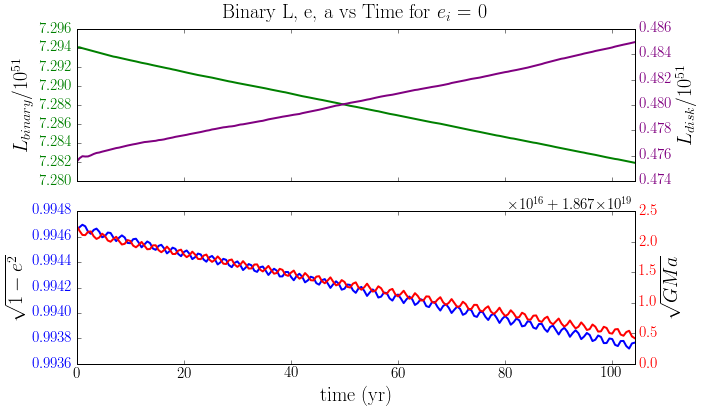

In [219]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)

#Top axis, left scale
axarr[0].plot(time, L/1.0e51,color='green',linewidth=2)
axarr[0].set_title('Binary L, e, a vs Time for $e_i$ = 0',y=1.02)
axarr[0].set_ylabel('$L_{binary}/10^{51}$')
axarr[0].set_xlim(time[0],time[-1])
for tl in axarr[0].get_yticklabels():
    tl.set_color('green')

#Top axis, right scale
ax3 = axarr[0].twinx()
ax3.plot(time, diskL/1.0e51, color='purple',linewidth=2)
ax3.set_ylabel('$L_{disk}/10^{51}$', color='black')
for tl in ax3.get_yticklabels():
    tl.set_color('purple')
ax3.set_xlim(time[0],time[-1])
    
#Bottom axis, left scale
axarr[1].plot(time, L_e,color='blue',linewidth=2)
for tl in axarr[1].get_yticklabels():
    tl.set_color('blue')
axarr[1].set_xlabel('time (yr)')
axarr[1].set_ylabel('$\sqrt{1-e^2}$', color='black')
axarr[1].set_xlim(time[0],time[-1])


#Bottom axis, right scale
ax2 = axarr[1].twinx()
ax2.plot(time, L_a, 'r',linewidth=2)
ax2.set_ylabel('$\sqrt{GMa}$', color='black')
for tl in ax2.get_yticklabels():
    tl.set_color('red')
ax2.set_xlim(time[0],time[-1])

#plt.savefig("30.10.2015.binALEe_0.1032_100yrs_dEta_0.01.pdf",bbox_inches='tight')

In [220]:
print L[-1] - L[0]
print diskL[-1] - diskL[0]

-1.21369140461e+49
9.41606072398e+48
